# **Neural Machine Translation with a Transformer and Keras**

>   Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<table align="center">
<tr align="center">
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr align="center">
  <td style="text-align: center">
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td style="text-align: center">
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

## **Environment**

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 36.9 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm

import tensorflow as tf
import tensorflow_text as tft  # preprocessing text
import tensorflow_datasets as tfds  # contains datasets

import logging
import matplotlib.pyplot as plt
import numpy as np

## **Resources**

### **Dataset**

In [3]:
data, metadata = tfds.load(
    name='ted_hrlr_translate/pt_to_en', # portugese to english
    with_info=True,
    as_supervised=True
)

train_x, val_x = data['train'], data['validation']
print(f"{metadata = }")
print(f"{train_x = }")
print(f"{val_x = }")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3U3YI9/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3U3YI9/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3U3YI9/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
metadata = tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path=PosixGPath('/tmp/tmpv5wz6l97tfds'),
    file_format=tfrecord,
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=string),
        'pt': Text(shape=(), dtype=string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
     

In [4]:
for pt_x, en_x in train_x.batch(4).take(1):
    print("Portuguese : ", type(pt_x))
    for i, pt in enumerate(pt_x.numpy()):
        print(i, pt.decode())

    print("\nEnglish : ", type(en_x))
    for i, en in enumerate(en_x.numpy()):
        print(i, en.decode())


Portuguese :  <class 'tensorflow.python.framework.ops.EagerTensor'>
0 e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
1 mas e se estes fatores fossem ativos ?
2 mas eles não tinham a curiosidade de me testar .
3 e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .

English :  <class 'tensorflow.python.framework.ops.EagerTensor'>
0 and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
1 but what if it were active ?
2 but they did n't test for curiosity .
3 and this conscious defiance is why i , as an agnostic , can still have faith .


### **Tokenizer**

In [5]:
MODEL_NAME = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f"{MODEL_NAME}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{MODEL_NAME}.zip",
    cache_dir=".",
    cache_subdir="",
    extract=True
)

tokenizer = tf.saved_model.load(MODEL_NAME)
tokenizer

184801/184801 [==============================] - 0s 0us/step


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fbfc7a72a10>

In [6]:
[item for item in dir(tokenizer.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [7]:
for _, en_x in train_x.batch(4).take(1):
    for en in en_x:
        encoded = tokenizer.en.tokenize([en])
        decoded = tokenizer.en.detokenize(encoded)
        print(f"{encoded = } \n {decoded = } \n")

print("Look up : ")
tokens = tokenizer.en.lookup(encoded)
tokens

encoded = <tf.RaggedTensor [[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308,
  74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]]> 
 decoded = <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'],
      dtype=object)> 

encoded = <tf.RaggedTensor [[2, 87, 90, 107, 76, 129, 1852, 30, 3]]> 
 decoded = <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'but what if it were active ?'], dtype=object)> 

encoded = <tf.RaggedTensor [[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]]> 
 decoded = <tf.Tensor: shape=(1,), dtype=string, numpy=array([b"but they did n ' t test for curiosity ."], dtype=object)> 

encoded = <tf.RaggedTensor [[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040,
  3176, 3186, 13, 94, 235, 89, 1938, 15, 3]]> 
 decoded = <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'and this conscious defiance is why i 

<tf.RaggedTensor [[b'[START]', b'and', b'this', b'conscious', b'de', b'##fi', b'##ance',
  b'is', b'why', b'i', b',', b'as', b'an', b'ag', b'##no', b'##stic',
  b',', b'can', b'still', b'have', b'faith', b'.', b'[END]']]>

### **Distribution of Samples in dataset**

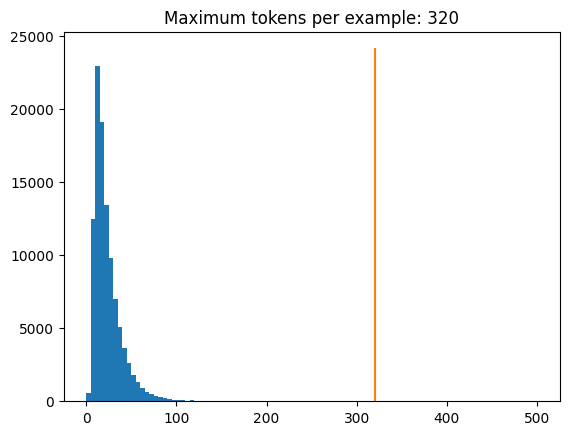

In [8]:
lengths = []
for pt_x, en_x in train_x.batch(1024):
    pt_tokens = tokenizer.pt.tokenize(pt_x)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizer.en.tokenize(en_x)
    lengths.append(en_tokens.row_lengths())

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [9]:
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [10]:
def prepare_batch(pt, en):
    pt = tokenizer.pt.tokenize(pt)
    pt = pt[:, :MAX_TOKENS]
    pt = pt.to_tensor()

    en = tokenizer.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()
    en_labels = en[:, 1:].to_tensor()

    return (pt, en_inputs), en_labels

In [11]:
def make_batches(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [12]:
train_batches = make_batches(train_x)
val_batches = make_batches(val_x)

<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

In [13]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 69)
(64, 66)
(64, 66)


### **Positional Encoding**

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})$$


In [14]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate(
        [
            np.sin(angle_rads),
            np.cos(angle_rads),
        ],
        axis=-1,
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


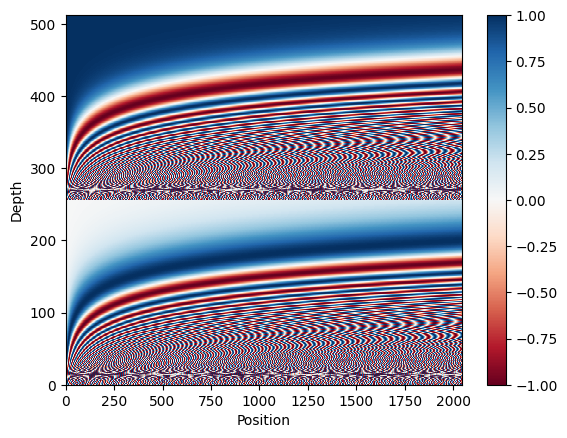

In [15]:
pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

> The positional encoding vectors have a property that the similarity between two vectors decreases as the distance between their positions increases. The dot-product is a measure of similarity that ranges from -1 (opposite directions) to 1 (same direction). The normalized vectors have unit length, so the dot-product is equal to the cosine of the angle between them.

In [16]:
pos_encoding.shape

TensorShape([2048, 512])

In [17]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)  # einstein summation
dots

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.17567034, 0.1883244 , 0.19303916, ..., 0.18210521, 0.17402971,
       0.1661976 ], dtype=float32)>

(0.0, 1.0)

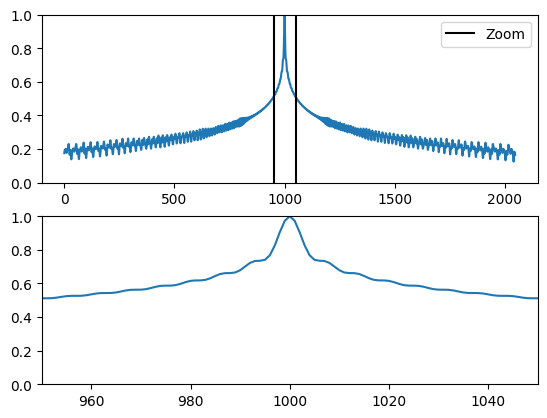

In [18]:
plt.subplot(2, 1, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot(
    [950, 950, float('nan'), 1050, 1050],
    [0,1,float('nan'),0,1], color='k', label='Zoom'
)
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim = d_model,
            mask_zero=True
        )
        self.pos_encoding = positional_encoding(
            length=2048,
            depth=d_model
        )

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)

        # This below factor sets the relative scale of the embedding and positional_encoding
        x *= tf.math.sqrt(
            tf.cast(self.d_model, tf.float32)
        )
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x


In [20]:
embed_pt = PositionalEmbedding(vocab_size=tokenizer.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizer.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [21]:
en_emb

<tf.Tensor: shape=(64, 66, 512), dtype=float32, numpy=
array([[[-0.34870726, -0.06550311, -0.10184053, ...,  0.18816698,
          0.9048495 ,  0.79247653],
        [-0.11308753,  0.25770748,  0.10546118, ...,  1.1398097 ,
          0.18352097,  1.6087081 ],
        [ 0.92906445, -0.08423793,  0.5347127 , ..., -0.11148703,
          1.1428388 ,  0.8825661 ],
        ...,
        [-0.49793112, -1.834463  ,  0.73363125, ...,  1.4143155 ,
          0.15508777,  0.23018622],
        [ 0.25473922, -1.8391421 , -0.00752814, ...,  1.4143146 ,
          0.155087  ,  0.23018557],
        [ 0.16154182, -1.0793892 , -0.85598886, ...,  1.4143138 ,
          0.15508628,  0.23018485]],

       [[-0.34870726, -0.06550311, -0.10184053, ...,  0.18816698,
          0.9048495 ,  0.79247653],
        [-0.11924088,  1.4148824 ,  1.0717876 , ...,  1.0593369 ,
          0.80519634,  0.5447695 ],
        [ 1.7270529 ,  0.8970567 ,  0.72458017, ...,  0.7378965 ,
          1.9618113 , -0.01033676],
        ...,

### **Attention Layer**

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

>
- The querys is what you're trying to find.
- The keys what sort of information the dictionary has.
- The value is that information.


In [22]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

In [23]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

In [24]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [25]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 69, 512)
(64, 66, 512)
(64, 66, 512)


<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

In [26]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [27]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 66, 512)
(64, 66, 512)


In [28]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

5.9604645e-07

### **Feed Forward Layer**

In [29]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x



In [30]:
sample_ffn = FeedForward(512, 2048)
print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 66, 512)
(64, 66, 512)


### **Encoder Layer**

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [32]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 69, 512)
(64, 69, 512)


In [33]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                            num_heads=num_heads,
                            dff=dff,
                            dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [34]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 69)
(64, 69, 512)


In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [36]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 66, 512)
(64, 69, 512)
(64, 66, 512)


In [37]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                    d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                            dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [38]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 66)
(64, 69, 512)
(64, 66, 512)


In [39]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 66, 69])

## **Transformer**

In [40]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                                num_heads=num_heads, dff=dff,
                                vocab_size=input_vocab_size,
                                dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                                num_heads=num_heads, dff=dff,
                                vocab_size=target_vocab_size,
                                dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [41]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [42]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate
)

In [43]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 66)
(64, 69)
(64, 66, 7010)


In [44]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 66, 69)


In [45]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10184162 (38.85 MB)
Trainable params: 10184162 (38.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Training**

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})$$

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

print(f"{learning_rate = }")
print(f"{optimizer = }")

learning_rate = <__main__.CustomSchedule object at 0x7fbfc7be7a60>
optimizer = <keras.src.optimizers.adam.Adam object at 0x7fbfc7d29a20>


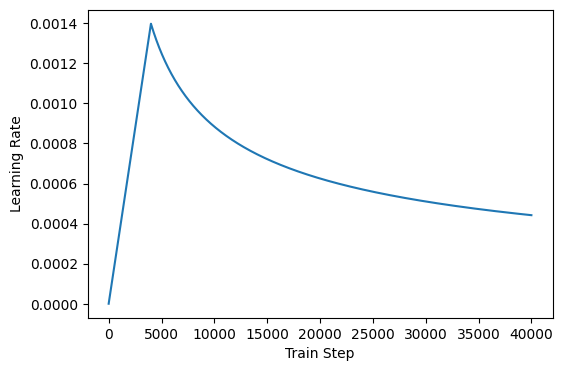

In [48]:
steps = tf.range(40000, dtype=tf.float32)
lr = learning_rate(steps)

plt.figure(figsize=(6, 4))  # Set the figure size
plt.plot(steps, lr)
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [49]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [50]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [51]:
transformer.fit(train_batches,
                epochs=5,
                validation_data=val_batches)

Epoch 1/5
810/810 [==============================] - 307s 333ms/step - loss: 6.5957 - masked_accuracy: 0.1344 - val_loss: 5.0399 - val_masked_accuracy: 0.2464
Epoch 2/5
810/810 [==============================] - 212s 262ms/step - loss: 4.5794 - masked_accuracy: 0.2972 - val_loss: 4.0489 - val_masked_accuracy: 0.3625
Epoch 3/5
810/810 [==============================] - 204s 252ms/step - loss: 3.8306 - masked_accuracy: 0.3792 - val_loss: 3.5663 - val_masked_accuracy: 0.4136
Epoch 4/5
810/810 [==============================] - 206s 254ms/step - loss: 3.2846 - masked_accuracy: 0.4390 - val_loss: 3.0420 - val_masked_accuracy: 0.4803
Epoch 5/5
810/810 [==============================] - 203s 250ms/step - loss: 2.8825 - masked_accuracy: 0.4848 - val_loss: 2.7323 - val_masked_accuracy: 0.5210


## **Inference**

In [52]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizer.en.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizer.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [53]:
translator = Translator(tokenizer, transformer)

In [54]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [55]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


## **Attention Plots**

In [56]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [58]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizer.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizer.pt.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

        plt.tight_layout()
        plt.show()

In [59]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [60]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizer.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizer.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [61]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

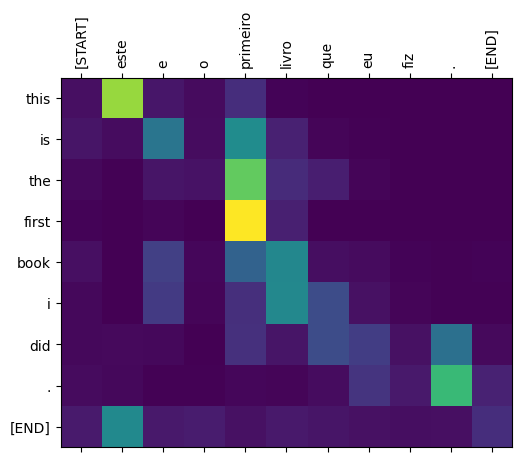

In [62]:
plot_attention_head(in_tokens, translated_tokens, attention)

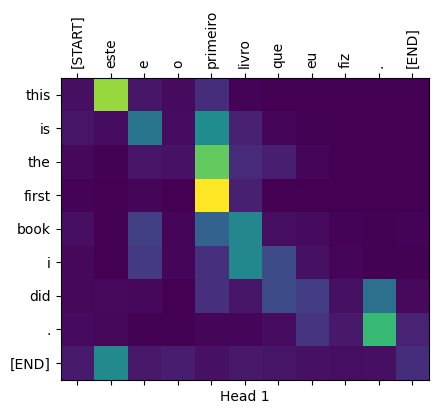

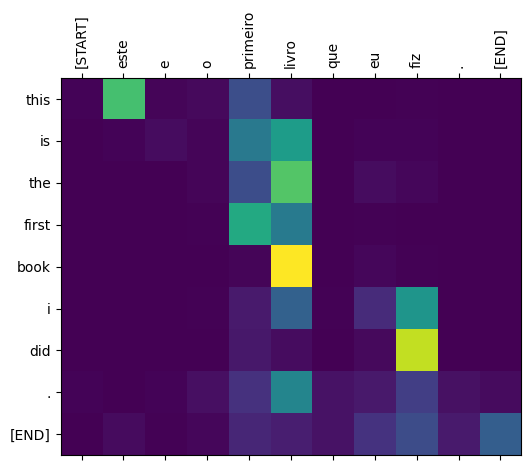

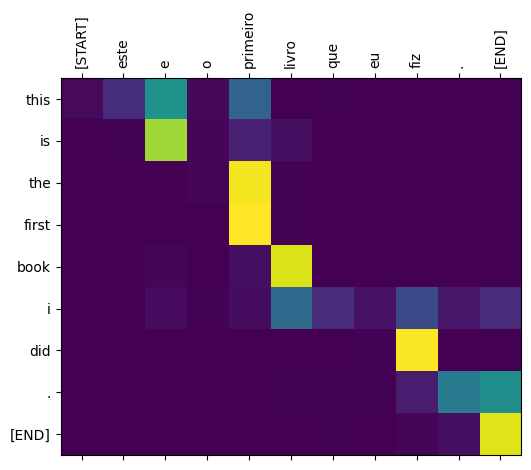

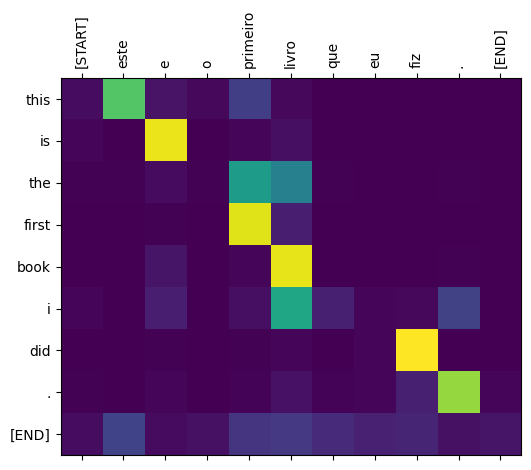

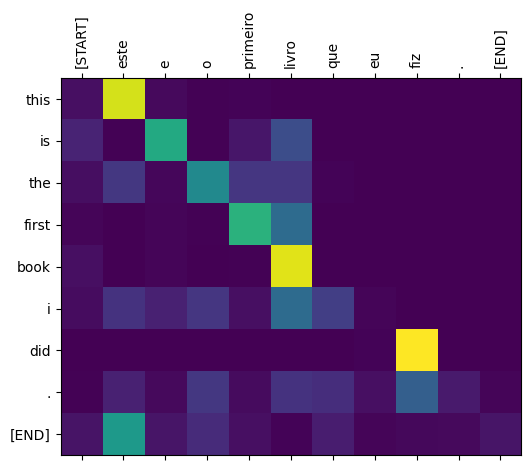

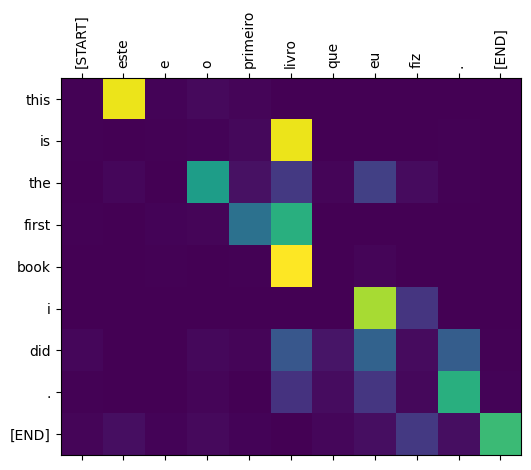

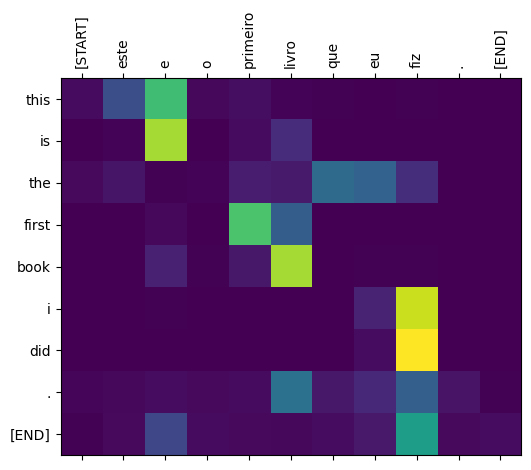

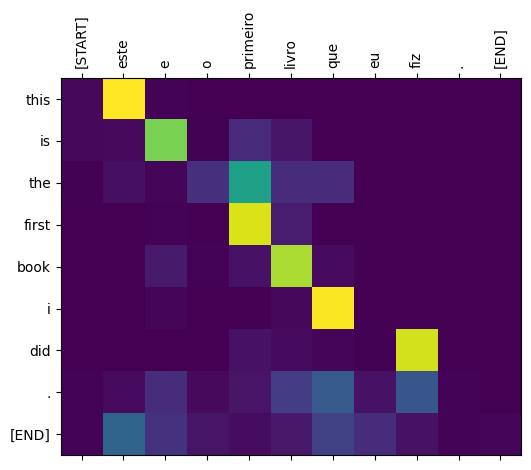

In [63]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## **Export**

In [64]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
            tokens,
            attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

        return result

In [65]:
translator = ExportTranslator(translator)

In [66]:
tf.saved_model.save(translator, export_dir='translator')